# EMG augmentation analysis

In [1]:
import sys
sys.path.append("../")

In [2]:
import pickle

from lift.datasets import (load_all_mad_datasets,
                           compute_features,
                           mad_labels_to_actions,
                           mad_groupby_labels,
                           mad_augmentation, )
from lift.environments.simulator import WindowSimulator

from configs import BaseConfig

/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


In [3]:
config = BaseConfig()
config.pretrain.num_augmentation = 10_000
config.pretrain.augmentation_distribution = 'uniform'
mad_windows, mad_labels = load_all_mad_datasets(
    config.mad_base_path.as_posix(),
    num_channels=config.n_channels,
    emg_range=config.emg_range,
    window_size=config.window_size,
    window_overlap=config.window_overlap,
    desired_labels=config.desired_mad_labels,
    skip_person='Female0',
    return_tensors=True,
)

mad_features = compute_features(mad_windows)
mad_actions = mad_labels_to_actions(mad_labels, recording_strength=config.simulator.recording_strength)

# augmentations
window_list, label_list = mad_groupby_labels(mad_windows, mad_labels)
actions_list = mad_labels_to_actions(
    label_list, recording_strength=config.simulator.recording_strength,
)
augmentation_windows, augmentation_actions = mad_augmentation(
    window_list, 
    actions_list, 
    config.pretrain.num_augmentation,
    augmentation_distribution=config.pretrain.augmentation_distribution
)
augmentation_features = compute_features(augmentation_windows)

skipping Female0
skipping Female0
skipping Female0
skipping Female0
MAD dataset loaded


In [4]:
rollout_file = config.rollout_data_path / f"data.pkl"
with open(rollout_file, "rb") as f:
    data = pickle.load(f)

sim = WindowSimulator(
    config,
    return_features=True,
)
sim.fit_params_to_mad_sample(
    (config.mad_data_path / "Female0"/ "training0").as_posix()
)

rollout_actions = data['act']
rollout_feats = sim(rollout_actions)
mad_sim_feats = sim(mad_actions)

INFO:root:Fitted simulator to MAD sample


In [5]:
import umap
reducer = umap.UMAP(
    n_neighbors=50, 
    n_components=2, 
    metric="euclidean",
    n_jobs=1,
    random_state=0,)
embedding = reducer.fit_transform(mad_features)
aug_embedding = reducer.transform(augmentation_features)
rollout_embedding = reducer.transform(rollout_feats)
mad_sim_embedding = reducer.transform(mad_sim_feats)

/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


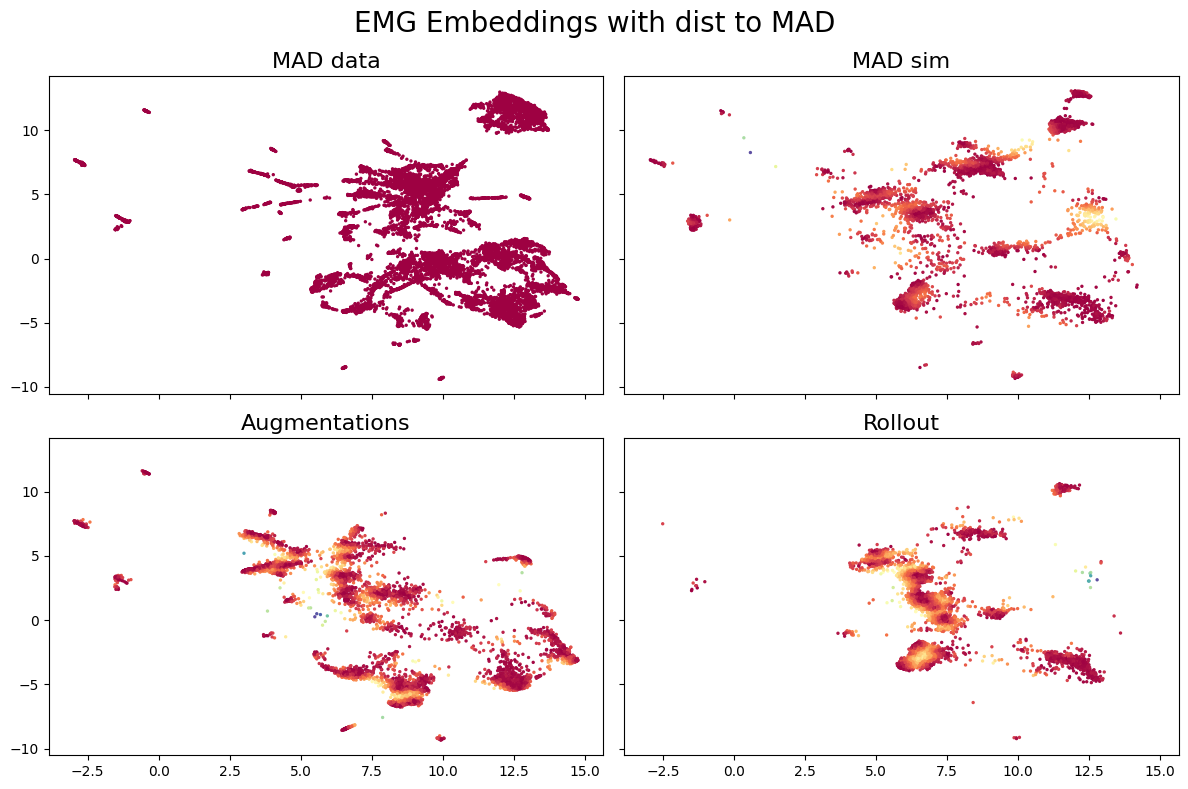

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

tree = KDTree(embedding)
mad_sim_dists, _ = tree.query(mad_sim_embedding)
aug_dists, _ = tree.query(aug_embedding)
rollout_dists, _ = tree.query(rollout_embedding)

mad_colors = np.ones_like(mad_sim_dists)

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
axs[0,0].scatter(embedding[:, 0], embedding[:, 1], c=mad_colors, cmap='Spectral', s=2)
axs[0,1].scatter(mad_sim_embedding[:, 0], mad_sim_embedding[:, 1], c=mad_sim_dists, cmap='Spectral', s=2)
axs[1,0].scatter(aug_embedding[:, 0], aug_embedding[:, 1], c=aug_dists, cmap='Spectral', s=2)
axs[1,1].scatter(rollout_embedding[:, 0], rollout_embedding[:, 1], c=rollout_dists, cmap='Spectral', s=2)

axs[0,0].set_title('MAD data', fontsize=16)
axs[0,1].set_title('MAD sim', fontsize=16)
axs[1,0].set_title('Augmentations', fontsize=16)
axs[1,1].set_title('Rollout', fontsize=16)

fig.suptitle(f'EMG Embeddings with dist to MAD', fontsize=20)

plt.tight_layout()

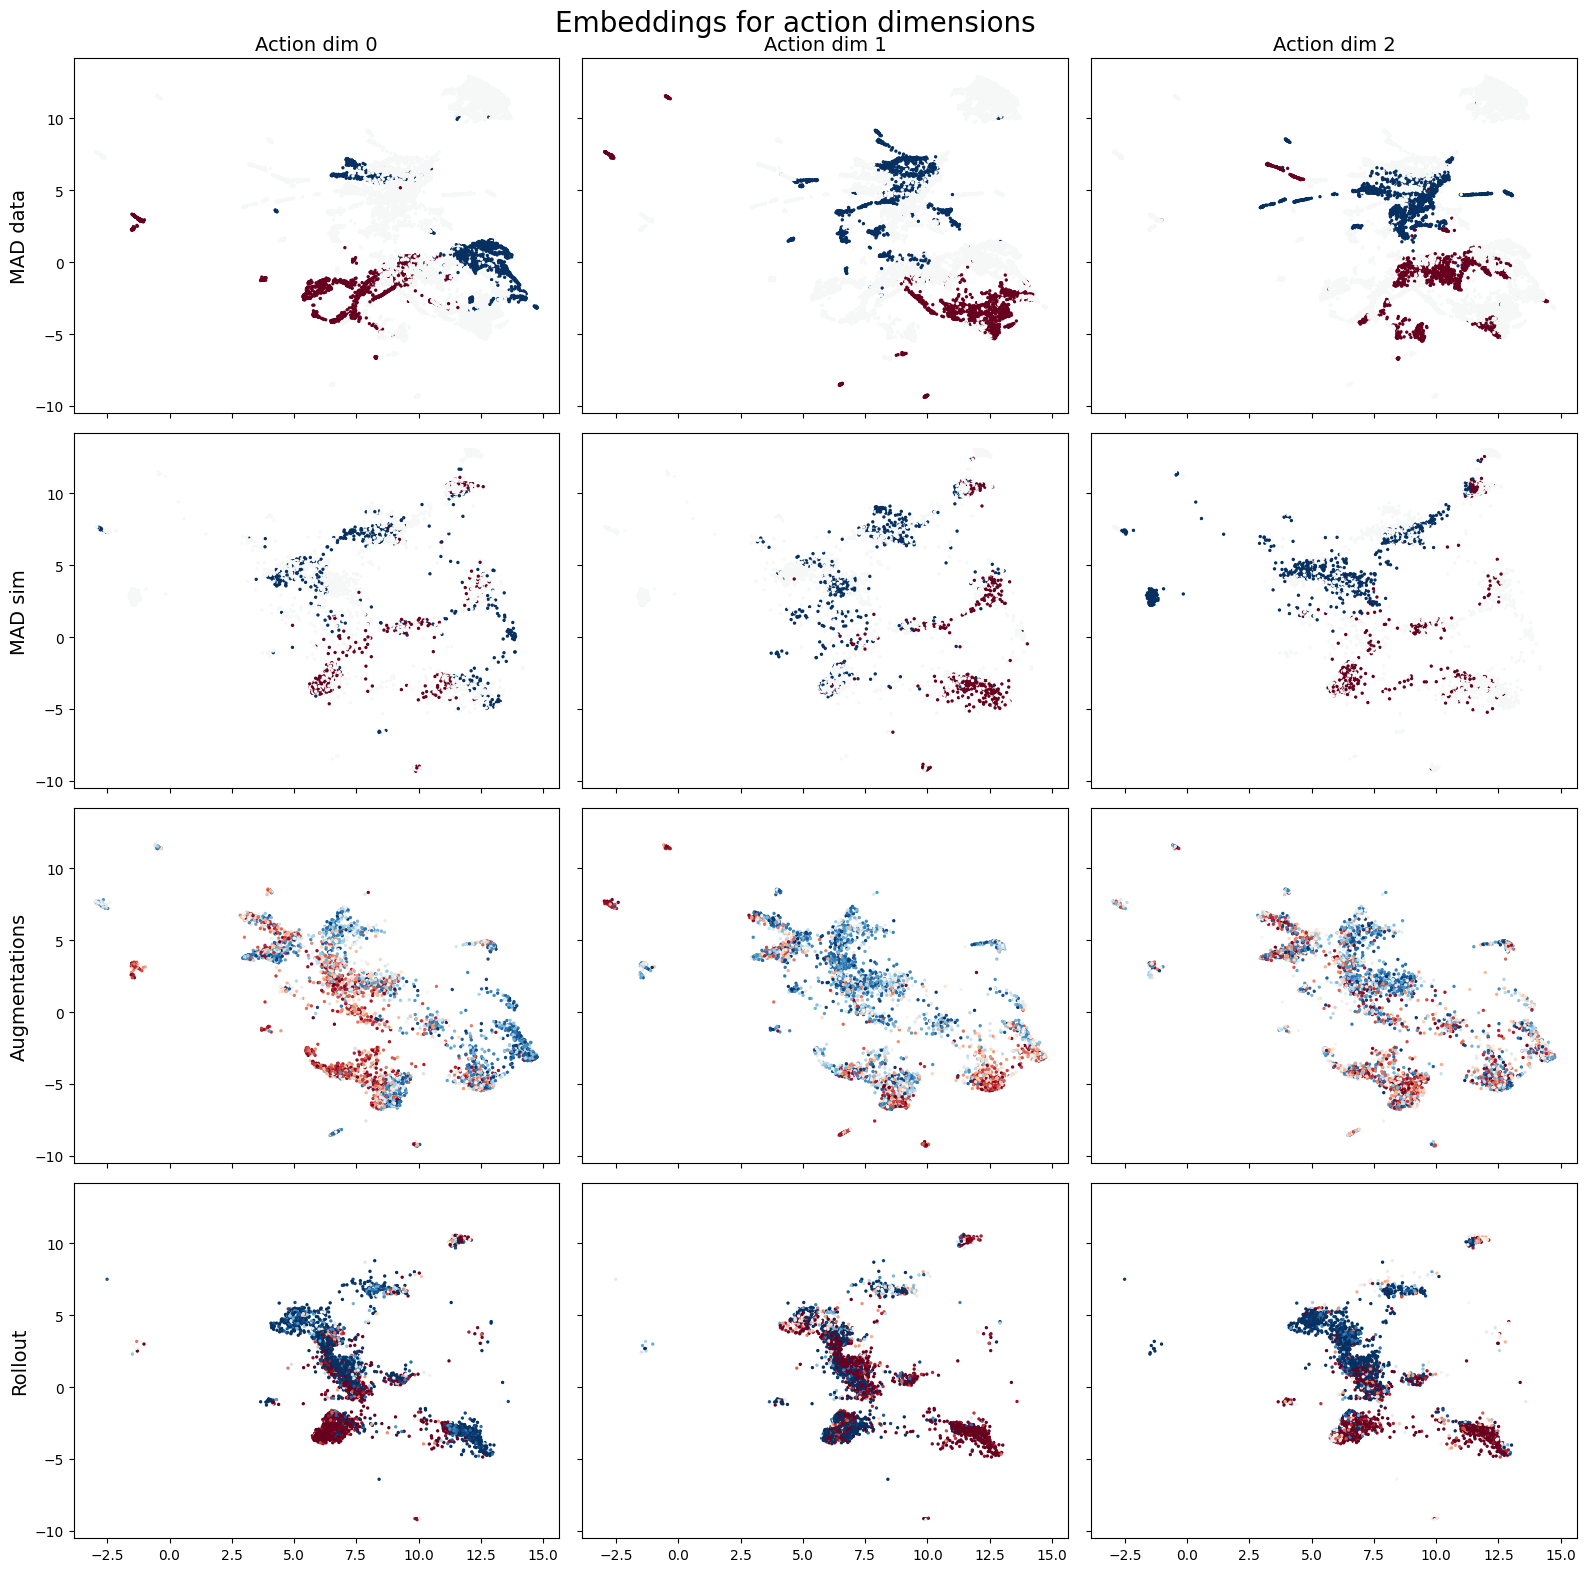

In [8]:
# plots per action dimension
fig, axs = plt.subplots(4, 3, figsize=(16,16), sharex=True, sharey=True)


for action_dim in range(3):
    mad_action_colors = mad_actions[:, action_dim]
    aug_action_colors = augmentation_actions[:, action_dim]
    rollout_action_colors = rollout_actions[:, action_dim]

    axs[0,action_dim].scatter(embedding[:, 0], embedding[:, 1], c=mad_action_colors, cmap='RdBu', s=2)
    axs[1,action_dim].scatter(mad_sim_embedding[:, 0], mad_sim_embedding[:, 1], c=mad_action_colors, cmap='RdBu', s=2)
    axs[2,action_dim].scatter(aug_embedding[:, 0], aug_embedding[:, 1], c=aug_action_colors, cmap='RdBu', s=2)
    ax = axs[3,action_dim].scatter(rollout_embedding[:, 0], rollout_embedding[:, 1], c=rollout_action_colors, cmap='RdBu', s=2)

    axs[0,action_dim].set_title(f'Action dim {action_dim}', fontsize=14)

axs[0, 0].set_ylabel('MAD data', fontsize=14)
axs[1, 0].set_ylabel('MAD sim', fontsize=14)
axs[2, 0].set_ylabel('Augmentations', fontsize=14)
axs[3, 0].set_ylabel('Rollout', fontsize=14)

fig.suptitle(f'Embeddings for action dimensions', fontsize=20)
plt.tight_layout()
plt.show()